In [3]:
import pandas as pd
import numpy as np
import yaml
import sys
import jax

sys.path.append("../../lib")
import utils
from nuance import Nuance

# Load data
params = yaml.full_load(open("../../data/gp.yaml", "r"))
df = pd.read_csv("../../data/lightcurves/P1.19026093_R0.51_1411.300973209267.csv")

time, flux, error = df.values.T
t_0 = time[0]
time -= t_0

X = utils.poly_X(time, 3)
kernel = utils.build_gp(params, time).kernel
nu = Nuance(time, flux, kernel=kernel, error=error, X=X)

In [4]:
# Mask flares
# In what Fran Pozuelos sent me, the falres are sigma clipped. To remove their
# full extended signal, I locate and mask 30 points on each side of "holes" in
# time
window = 30
mask = np.pad(np.array(np.diff(time) < 3*np.median(np.diff(time))), (0, 1))
ups = np.flatnonzero(~mask)
if len(ups) > 0:
    mask[
        np.hstack(
            [
                np.arange(max(u - window, 0), min(u + window, len(nu.time)))
                for u in ups
            ]
        )
    ] = False

nu = Nuance(time[mask], flux[mask], error[mask], kernel=kernel, X=X[:, mask])

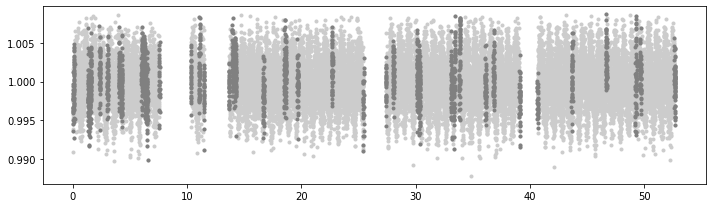

In [5]:
import matplotlib.pyplot as plt

plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time[~mask], flux[~mask], ".", c="0.5")
plt.tight_layout()

In [7]:
# linear search
t0s = time.copy()
Ds = np.linspace(0.01, 0.07, 6)
nu.linear_search(t0s, Ds)

# We mask directly the first planet signal
nu = nu.mask(0.9236153776066658, 0.02, 1.2390692712847524)

# Search of the second
periods = np.linspace(0.9, 10.1, 8000)
#search = nu.periodic_search(periods)

100%|██████████████████████████████████████████████████████| 31430/31430 [00:40<00:00, 782.34it/s]


# New

In [8]:
self = nu.search_data

In [10]:
import jax
import jax.numpy as jnp

In [101]:
from functools import partial

def interp_split_times(time, p):
    dt = jnp.median(np.diff(time))
    tmax, tmin = jnp.max(time), jnp.min(time)
    total = tmax - tmin
    # since for very small periods we might fold on few points only, it's better to impose
    # at least 200 phases, to compare period folds more fairly
    phase = np.arange(0, 1, jnp.min(jnp.array([dt, dt/p])))
    n = jnp.arange(np.ceil(total/p)) # number of 'folds'
    pt0s = jnp.array([tmin + phase*p + j*p for j in n]) # corresponding t0s
    has_time = jnp.any(jnp.array([jnp.abs(time - _t0) < p/2 for _t0 in pt0s.mean(1)]), 1)
    pt0s = pt0s[has_time]
    
    return pt0s

@partial(jnp.vectorize, signature="(n),(m),(m)->(n)")
def phase_interpolation(phase, time, f):
    return jnp.interp(phase, time, f)

In [ ]:
@property
def fold_ll(self):
    folds = self.folds

    def _fold(p):
        pt0s, (lls, zs, vzs) = folds(p) 
        P1 = np.sum(lls, 0)
        vZ = 1/np.sum(1/vzs, 0)
        Z = vZ * np.sum(zs/vzs, 0)
        P1 = np.sum(lls, 0)
        P2 = 0.5*np.sum(np.log(vzs) - np.log(vzs + vZ) + (zs-Z)**2/(vzs+vZ), 0)

        return pt0s[0]/p, P1, P1-P2

    return _fold

In [ ]:
@partial(jnp.vectorize, signature="(n),(m),(d,m)->(d,n)")
def phase_interpolation(phase, time, f):
    return jnp.vstack([jnp.interp(phase, time, _f) for _f in f])

@partial(jnp.vectorize, signature="(a,n),(m),(d,m),(d,m),(d,m)->(d,n)")
def A(phased_t0s, t0s, ll, z, vz):
    lls = phase_interpolation(phased_t0s, t0s, ll)
    zs = phase_interpolation(phased_t0s, t0s, z)
    vzs = phase_interpolation(phased_t0s, t0s, vz)
    P1 = jnp.sum(lls, 0)
    vZ = 1/jnp.sum(1/vzs, 0)
    Z = vZ * jnp.sum(zs/vzs, 0)
    P1 = jnp.sum(lls, 0)
    P2 = 0.5*jnp.sum(jnp.log(vzs) - jnp.log(vzs + vZ) + (zs-Z)**2/(vzs+vZ), 0)

    return P1-P2

In [236]:
from tqdm import tqdm

for p in tqdm(periods):
    #pt0s = interp_split_times(self.t0s, p)
    test = A(pt0s, self.t0s, self.ll.T, self.z.T, self.vz.T)

  7%|████                                                      | 564/8000 [00:25<05:36, 22.08it/s]


KeyboardInterrupt: 

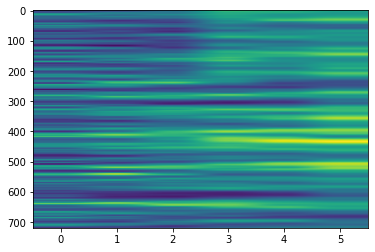

In [232]:
plt.imshow(nu.search_data.fold_ll(1.)[1], aspect='auto')

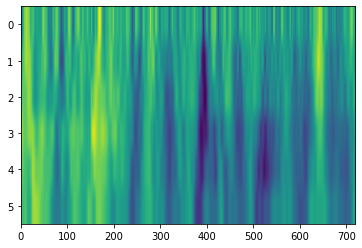

In [233]:
pt0s = interp_split_times(self.t0s, 1.)
test = A(pt0s, self.t0s, self.ll.T, self.z.T, self.vz.T)

plt.imshow(test, aspect='auto')

In [116]:
pt0s.shape

(49, 720)

In [108]:
self.ll.shape

(29511, 6)

In [29]:
self.ll[:, 0].shape

(29511,)

In [34]:
jnp.interp(pt0s[0], self.t0s, self.ll[:, 0])

DeviceArray([133089.07167206, 133089.0986855 , 133089.12569895,
             133089.11535792, 133089.10501561, 133089.16011821,
             133089.21522531, 133089.15810183, 133089.10096679,
             133089.34105424, 133089.5811826 , 133089.66872645,
             133089.75624406, 133089.61211147, 133089.46793105,
             133089.27002741, 133089.07211082, 133089.12588265,
             133089.17972375, 133089.20721207, 133089.23469223,
             133089.30985845, 133089.38504108, 133089.36540292,
             133089.34572885, 133089.40469085, 133089.46368533,
             133089.58457694, 133089.70549626, 133089.91535353,
             133090.12525367, 133090.00609815, 133089.88677265,
             133089.78556985, 133089.68437705, 133089.67950823,
             133089.67469581, 133089.67451956, 133089.67434618,
             133089.67433988, 133089.6743337 , 133089.37321557,
             133089.07188995, 133089.07167206, 133089.07167206,
             133089.07167206, 133089.071

In [ ]:
def folds(self):

    f_ll = interp2d(self.Ds, self.t0s, self.ll)
    f_z = interp2d(self.Ds, self.t0s, self.z)
    f_dz2 = interp2d(self.Ds, self.t0s, self.vz)

    def interpolate_all(pt0s):
        # computing the likelihood folds by interpolating in phase
        folds_ll = np.array([f_ll(self.Ds, t) for t in pt0s])
        folds_z = np.array([f_z(self.Ds, t) for t in pt0s])
        folds_vz = np.array([f_dz2(self.Ds, t) for t in pt0s])

        return folds_ll, folds_z, folds_vz

    def _folds(p):
        pt0s = utils.interp_split_times(self.t0s, p)
        return pt0s, interpolate_all(pt0s)

    return _folds